In [1]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests
import pandas as pd
import os
from tqdm.auto import tqdm
import glob
import multiprocessing as mp
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from torchviz import make_dot
from ptflops import get_model_complexity_info
import time
import sys


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')


Running on device: cuda:0


# Training Data

In [14]:
train_dir = 'D:\\W\\VS\\VS Folder\\DFD\\DFDC MTCNN Extracted\\'
train_df = pd.read_csv(os.path.join(train_dir, 'metadata.csv'))
train_df['path'] = train_df['filename'].apply(lambda x: os.path.join(train_dir, x.split('.')[0]))

# Remove empty folders
train_df = train_df[train_df['path'].map(lambda x: os.path.exists(x))]
train_df

,filename,label,split,original,path
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aag...
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aap...
2,abarnvbtwb.mp4,REAL,train,NaN,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aba...
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\abo...
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\abq...
...,...,...,...,...,...
395,etejaapnxh.mp4,FAKE,train,wtreibcmgm.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\ete...
396,etmcruaihe.mp4,FAKE,train,afoovlsmtx.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\etm...
397,etohcvnzbj.mp4,FAKE,train,bdnaqemxmr.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\eto...
398,eudeqjhdfd.mp4,REAL,train,NaN,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\eud...


In [15]:
valid_train_df = pd.DataFrame(columns=['filename', 'label', 'split', 'original', 'path'])

# for row_idx, row in tqdm(train_df.iterrows()):
for row_idx in tqdm(train_df.index):
    row = train_df.loc[row_idx]
    img_dir = row['path']
    face_paths = glob.glob(f'{img_dir}/*.png')

    if len(face_paths) >= 5: # Satisfy the minimum requirement for the number of faces
        face_indices = [
            path.split('\\')[-1].split('.')[0].split('_')[0]
            for path in face_paths
        ]
        max_idx = np.max(np.array(face_indices, dtype=np.uint32))

        selected_paths = []

        for i in range(5):
            stride = int((max_idx + 1)/(5**2))
            sample = np.linspace(i*stride, max_idx + i*stride, 5).astype(int)

            # Get faces
            for idx in sample:
                paths = glob.glob(f'{img_dir}/{idx}*.png')

                selected_paths.extend(paths)
                if len(selected_paths) >= 5: # Get enough faces
                    break

            if len(selected_paths) >= 5:  # Get enough faces
                valid_train_df = pd.concat([valid_train_df, pd.DataFrame([row])], ignore_index=True)
                break

  0%|          | 0/400 [00:00<?, ?it/s]

In [16]:
valid_train_df['label']=valid_train_df['label'].replace({'FAKE': 1, 'REAL': 0})
display(valid_train_df.head())

label_count = valid_train_df.groupby('label').count()['filename']
print(label_count)

x = valid_train_df['path'].to_numpy()
y = valid_train_df['label'].to_numpy()

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=224, stratify=y)

np.savez('train_test_split.npz',
         x_train=x_train,
         x_val=x_val,
         y_train=y_train,
         y_val=y_val)

C:\Users\rachi\AppData\Local\Temp\ipykernel_21020\3380636837.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  valid_train_df['label']=valid_train_df['label'].replace({'FAKE': 1, 'REAL': 0})


,filename,label,split,original,path
0,aagfhgtpmv.mp4,1,train,vudstovrck.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aag...
1,aapnvogymq.mp4,1,train,jdubbvfswz.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aap...
2,abarnvbtwb.mp4,0,train,NaN,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aba...
3,abqwwspghj.mp4,1,train,qzimuostzz.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\abq...
4,acifjvzvpm.mp4,1,train,kbvibjhfzo.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aci...


label
0     76
1    306
Name: filename, dtype: int64


# Training - Feature extraction and classifier

In [14]:
data = np.load('train_test_split.npz', allow_pickle=True)
x_train = data['x_train']
y_train = data['y_train']

### Model

In [35]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch32-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch32-224-in21k')
model = model.to(device)
classifier = nn.Linear(768, 1)
classifier = classifier.to(device)
criterion = nn.BCEWithLogitsLoss()  # For binary classification


In [33]:
model.train()
classifier.train()

# freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# unfreeze n layer parameters
n = 4
for layer in model.encoder.layer[-n:]:
    for param in layer.parameters():
        param.requires_grad = True
    display(f'Unfreezing layer: {layer}')

for param in classifier.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(
    list(classifier.parameters()) +
    [p for p in model.parameters() if p.requires_grad == True],
    lr=1e-4
)

print(model)
print(classifier)




'Unfreezing layer: ViTLayer(\n  (attention): ViTAttention(\n    (attention): ViTSelfAttention(\n      (query): Linear(in_features=768, out_features=768, bias=True)\n      (key): Linear(in_features=768, out_features=768, bias=True)\n      (value): Linear(in_features=768, out_features=768, bias=True)\n    )\n    (output): ViTSelfOutput(\n      (dense): Linear(in_features=768, out_features=768, bias=True)\n      (dropout): Dropout(p=0.0, inplace=False)\n    )\n  )\n  (intermediate): ViTIntermediate(\n    (dense): Linear(in_features=768, out_features=3072, bias=True)\n    (intermediate_act_fn): GELUActivation()\n  )\n  (output): ViTOutput(\n    (dense): Linear(in_features=3072, out_features=768, bias=True)\n    (dropout): Dropout(p=0.0, inplace=False)\n  )\n  (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)\n  (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)\n)'

'Unfreezing layer: ViTLayer(\n  (attention): ViTAttention(\n    (attention): ViTSelfAttention(\n      (query): Linear(in_features=768, out_features=768, bias=True)\n      (key): Linear(in_features=768, out_features=768, bias=True)\n      (value): Linear(in_features=768, out_features=768, bias=True)\n    )\n    (output): ViTSelfOutput(\n      (dense): Linear(in_features=768, out_features=768, bias=True)\n      (dropout): Dropout(p=0.0, inplace=False)\n    )\n  )\n  (intermediate): ViTIntermediate(\n    (dense): Linear(in_features=768, out_features=3072, bias=True)\n    (intermediate_act_fn): GELUActivation()\n  )\n  (output): ViTOutput(\n    (dense): Linear(in_features=3072, out_features=768, bias=True)\n    (dropout): Dropout(p=0.0, inplace=False)\n  )\n  (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)\n  (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)\n)'

'Unfreezing layer: ViTLayer(\n  (attention): ViTAttention(\n    (attention): ViTSelfAttention(\n      (query): Linear(in_features=768, out_features=768, bias=True)\n      (key): Linear(in_features=768, out_features=768, bias=True)\n      (value): Linear(in_features=768, out_features=768, bias=True)\n    )\n    (output): ViTSelfOutput(\n      (dense): Linear(in_features=768, out_features=768, bias=True)\n      (dropout): Dropout(p=0.0, inplace=False)\n    )\n  )\n  (intermediate): ViTIntermediate(\n    (dense): Linear(in_features=768, out_features=3072, bias=True)\n    (intermediate_act_fn): GELUActivation()\n  )\n  (output): ViTOutput(\n    (dense): Linear(in_features=3072, out_features=768, bias=True)\n    (dropout): Dropout(p=0.0, inplace=False)\n  )\n  (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)\n  (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)\n)'

'Unfreezing layer: ViTLayer(\n  (attention): ViTAttention(\n    (attention): ViTSelfAttention(\n      (query): Linear(in_features=768, out_features=768, bias=True)\n      (key): Linear(in_features=768, out_features=768, bias=True)\n      (value): Linear(in_features=768, out_features=768, bias=True)\n    )\n    (output): ViTSelfOutput(\n      (dense): Linear(in_features=768, out_features=768, bias=True)\n      (dropout): Dropout(p=0.0, inplace=False)\n    )\n  )\n  (intermediate): ViTIntermediate(\n    (dense): Linear(in_features=768, out_features=3072, bias=True)\n    (intermediate_act_fn): GELUActivation()\n  )\n  (output): ViTOutput(\n    (dense): Linear(in_features=3072, out_features=768, bias=True)\n    (dropout): Dropout(p=0.0, inplace=False)\n  )\n  (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)\n  (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)\n)'

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

### Train

In [ ]:


batch_size = 24
labels = []
video_paths = x_train
video_labels = y_train
total_batches = 0




# x = ...  # your input tensor, shape (batch, 3, 224, 224)
# outputs = vit(x)
# cls_token = outputs.last_hidden_state[:, 0]  # [CLS] token
# logits = classifier(cls_token)  # shape (batch, 1)

num_epochs = 20  # Adjust as needed
train_loss=np.zeros(num_epochs)

start_time = time.time()

epoch_bar = tqdm(range(num_epochs), desc='Epochs')
for epoch in epoch_bar:
    model.train()
    classifier.train()

    running_loss = 0.0
    total_batches = 0

    video_bar = tqdm(zip(video_paths, video_labels),desc='Videos', total=len(video_paths))
    for path, label in video_bar:
        image_files = sorted([ os.path.join(path, f)
        for f in os.listdir(path)
        if f.lower().endswith('.png')
        ])

        labels.extend([label] * len(image_files))  # Repeat label for each image

        video_run_loss=0.0
        batches = 0

        for i in range(0, len(image_files), batch_size):
            batch_paths = image_files[i:i+batch_size]
            images = [Image.open(p).convert("RGB") for p in batch_paths]
            inputs = processor(images=images, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}

            batch_labels = torch.tensor([label] * len(images), dtype=torch.float).unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # (batch, hidden_dim)
            batch_logits = classifier(cls_embeddings)  # (batch, 1)
            loss = criterion(batch_logits, batch_labels)
            loss.backward()
            optimizer.step()

            loss_item = loss.item()
            running_loss += loss_item
            video_run_loss += loss_item

            batches += 1
            total_batches += 1

            

        video_loss = video_run_loss / batches if batches > 0 else 0
        video_bar.set_postfix(Last_Loss=f'{video_loss:.4f}')
        
    avg_loss = running_loss / total_batches if total_batches > 0 else 0
    train_loss[epoch] = avg_loss
    epoch_bar.set_postfix(Curr_Loss=f'{avg_loss:.4f}')

end_time = time.time()
training_time = end_time - start_time

# Save model backbone
torch.save(model.state_dict(), 'vit_backbone.pth')

# Save classifier head
torch.save(classifier.state_dict(), 'vit_classifier_head.pth')



Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Videos:   0%|          | 0/267 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Videos:   0%|          | 0/267 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Videos:   0%|          | 0/267 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Videos:   0%|          | 0/267 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Videos:   0%|          | 0/267 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
print(inputs["pixel_values"].shape)
print(f"Training completed in {training_time/60:.2f} minutes")


torch.Size([12, 3, 224, 224])
Training completed in 222.35 minutes


Log Loss Graph

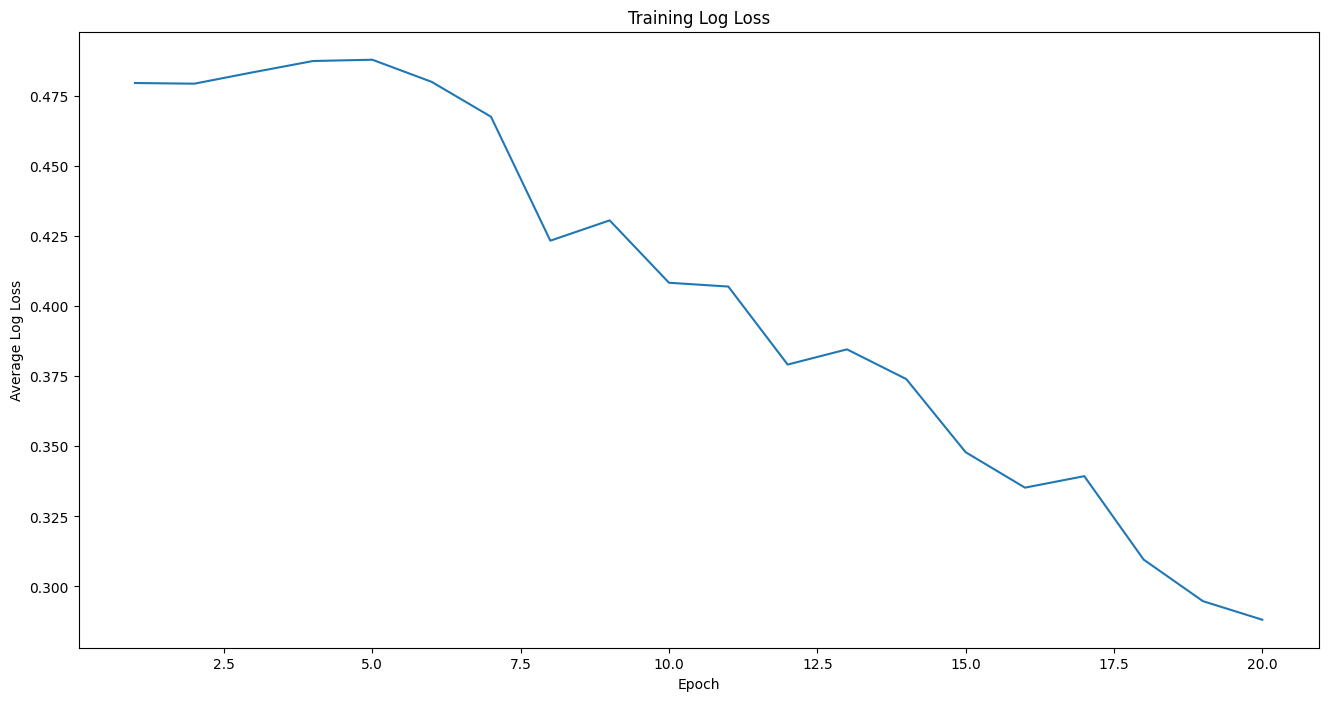

In [11]:
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(16, 8))
plt.plot(epochs, train_loss)
plt.title('Training Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Log Loss')
plt.show()


# Validation

In [36]:
model.load_state_dict(torch.load('vit_backbone.pth'))
classifier.load_state_dict(torch.load('vit_classifier_head.pth'))
model = model.to(device)
classifier = classifier.to(device)



### Model and Data

In [26]:
data = np.load('train_test_split.npz', allow_pickle=True)
x_val = data['x_val']
y_val = data['y_val']


In [ ]:
batch_size = 24
video_paths = x_val
video_labels = y_val
labels = []

model.eval()
classifier.eval()

running_loss = 0.0
total_batches = 0
total_images = 0
correct = 0
total = 0

start_time = time.time()

video_bar = tqdm(zip(video_paths, video_labels),desc='Videos', total=len(video_paths))
for path, label in video_bar:
    image_files = sorted([ os.path.join(path, f)
    for f in os.listdir(path)
    if f.lower().endswith('.png')
    ])

    labels.extend([label] * len(image_files))  # Repeat label for each image
    total_images += len(image_files)

    for i in tqdm(range(0, len(image_files), batch_size), desc='Image Batches', leave=False):
        total_batches += 1
        batch_paths = image_files[i:i+batch_size]
        images = [Image.open(p).convert("RGB") for p in batch_paths]
        inputs = processor(images=images, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        batch_labels = torch.tensor([label] * len(images), dtype=torch.float).unsqueeze(1).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # (batch, hidden_dim)
            outputs = classifier(cls_embeddings)  # (batch, 1)

            running_loss += criterion(outputs, batch_labels).item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == batch_labels.int()).sum().item()
            total += batch_labels.size(0)

    accuracy = correct / total
    val_loss = running_loss / total_batches if total_batches > 0 else 0

end_time = time.time()
vali_time = end_time - start_time
vali_inf_time = vali_time / total_images
vali_fps = total_images / vali_time

print(f"Validation Accuracy: {accuracy*100:.2f}%")
print(f"Validation Log Loss: {val_loss:.4f}")

print(f"Validation Time: {vali_time/60:.2f} minutes")
print(f"Validation Single Inference Time: {vali_inf_time:.2f} seconds")
print(f"Validation FPS: {vali_fps:.2f} images/second")




###########################################################################################################################

# for path, label in tqdm(zip(video_paths, video_labels),desc='Videos', total=len(video_paths)):
#     image_files = sorted([ os.path.join(path, f)
#     for f in os.listdir(path)
#     if f.lower().endswith('.png')
#     ])

#     feat_labels.extend([label] * len(image_files))  # Repeat label for each image

#     for i in tqdm(range(0, len(image_files), batch_size), desc='Image Batches', leave=False):
#         batch_paths = image_files[i:i+batch_size]
#         images = [Image.open(p).convert("RGB") for p in batch_paths]
#         inputs = processor(images=images, return_tensors="pt")
#         inputs = {k: v.to(device) for k, v in inputs.items()}


#         with torch.no_grad():
#             outputs = model(**inputs)
#             cls_embeddings = outputs.last_hidden_state[:, 0, :]  # (batch, hidden_dim)
#             features.append(cls_embeddings.cpu())


# val_features = torch.cat(features, dim=0)  # (total_num_images, hidden_dim)
# val_feat_labels = torch.tensor(feat_labels)

# torch.save(val_features, 'val_features.pt')
# torch.save(val_feat_labels, 'val_feat_labels.pt')


#########################################################################3#################################################

# classifier.eval()
# correct = 0
# total = 0
# batch_loss = 0.0
# with torch.no_grad():
#     batch_bar = tqdm(val_loader, desc='Batches')
#     for features_batch, labels_batch in batch_bar:
#         features_batch = features_batch.to(device)
#         labels_batch = labels_batch.float().unsqueeze(1).to(device)
#         outputs = classifier(features_batch)

#         batch_loss += criterion(outputs, labels_batch).item()
#         preds = (torch.sigmoid(outputs) > 0.5).int()
#         correct += (preds == labels_batch.int()).sum().item()
#         total += labels_batch.size(0)
# accuracy = correct / total
# val_loss = batch_loss / len(val_loader)
# print(f"Validation Accuracy: {accuracy*100:.2f}%")
# print(f"Validation Log Loss: {val_loss:.4f}")



Videos:   0%|          | 0/115 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Validation Accuracy: 82.75%
Validation Log Loss: 0.4798
Validation Time: 8.42 minutes
Validation Single Inference Time: 0.01 seconds
Validation FPS: 76.56 images/second


Measuring Gflops

In [16]:


# Replace this with your actual model instance
input_shape = (3, 224, 224)  # Typical for ViT, adjust as needed

macs, params = get_model_complexity_info(
    model, input_shape, as_strings=False, print_per_layer_stat=True, backend='aten'
)
print(f"FLOP: {2*macs/1000000000:.2f} GFLOP")
print(f"Params: {params/1000000:.2f} M")


Total:4.37 GMac
Module:  Global
aten.convolution: 115.64 MMac
aten.addmm: 4.25 GMac

Module:  embeddings
aten.convolution: 115.64 MMac

Module:  encoder
aten.addmm: 4.25 GMac

Module:  pooler
aten.addmm: 590.59 KMac

FLOP: 8.73 GFLOP
Params: 28.35 M
